# Data collation

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("Witchcraft_and_the_Press_Data_CSV.csv")


def number_to_category(num):
    map = {
        1: "Violence",
        2: "Traditional Medicine/Healing",
        3: "Politics/Law",
        4: "Economics",
        5: "Religion",
        6: "Education",
        7: "Society/other",
    }
    return map.get(num, np.nan)


def get_year(date):
    if pd.isnull(date):
        return np.nan
    last_two = int(date.split("/")[-1])
    if last_two >= 60:
        return 1900 + last_two
    else:
        return 2000 + last_two


def get_country(country):
    if country == "TAN":
        return "Tanzania"
    if country == "KEN":
        return "Kenya"
    if country == "UGA":
        return "Uganda"
    return np.nan


df["category"] = df["Category"].map(number_to_category)
df["year"] = df["Date"].map(get_year)
df["summary"] = df["Descriptor"]
df["country"] = df["Country"].map(get_country)

df = df["summary country year category".split()]
df = df.dropna().reset_index(drop=True)

df

,summary,country,year,category
0,"A European geologist, age 22, was killed by Go...",Tanzania,1960.0,Violence
1,Police have arrested 56 administrators of Mau ...,Kenya,1960.0,Violence
2,"A man in Paidha, Uganda, ran amok with a mache...",Uganda,1960.0,Violence
3,"A tribal chief in Papati, Uganda, was jailed f...",Uganda,1960.0,Violence
4,"Two women from Rufiji District, Tanzania, conf...",Tanzania,1961.0,Violence
...,...,...,...,...
507,Many soccer experts attribute the Ugandan nati...,Uganda,1999.0,Society/other
508,"A mob in Bamunaanika, Uganda lynched an old ma...",Uganda,2003.0,Society/other
509,A woman lost custody of her daughter because s...,Kenya,2009.0,Society/other
510,Two children were rescued from being starved b...,Uganda,2009.0,Society/other


## Question answering via Google's Gemini Pro

In [2]:
import google.generativeai as genai


with open("GOOGLE_API_KEY.txt", "r") as f:
    GOOGLE_API_KEY = f.read().strip()

genai.configure(api_key=GOOGLE_API_KEY)
model = genai.GenerativeModel("models/gemini-1.0-pro")

/home2/hstropkay/witchcraft/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
questions = [
    (
        "region",
        "In what region did this event occur?",
    ),
    (
        "injuries",
        "Were there injuries due to witchcraft-related violence?",
    ),
    (
        "death",
        "Was there death due to witchcraft-related violence?",
    ),
    (
        "property_damage",
        "Was there property damage due to witchcraft-related violence?",
    ),
    (
        "property_ownership",
        "If there was property damage, who owned the property? Answer with 'individual', 'community', or 'government'.",
    ),
    (
        "perpetrators",
        "Did anyone commit witchcraft-related violence?",
    ),
    (
        "perpetrators_direction",
        "If anyone committed witchcraft-related violence, was the violence directed toward people accused of witchcraft or was the violence perpetrated by people accused of violence? Answer with 'toward' or 'by'.",
    ),
    (
        "perpetrators_group_size",
        "If anyone committed witchcraft-related violence, what was the size of the group? Answer with 'individual' if the group includes 1 individual, 'small' if the group includes 2-10 individuals, and 'large' if the group includes 10 or more individuals.",
    ),
    (
        "perpetrator_sex",
        "If anyone committed witchcraft-related violence, what was the predominant sex of the group or the individual? Answer with 'male', 'female', or 'mixed'.",
    ),
    (
        "victims",
        "Did anyone fall victim of witchcraft-related violence?",
    ),
    (
        "victims_group_size",
        "If anyone fell victim to witchcraft-related violence, what was the size of the group? Answer with 'individual' if the group includes 1 individual, 'small' if the group includes 2-10 individuals, and 'large' if the group includes 10 or more individuals.",
    ),
    (
        "victims_sex",
        "If anyone fell victim to witchcraft-related violence, what was the predominant sex of the group or the individual? Answer with 'male', 'female', or 'mixed'.",
    ),
    (
        "police_involvement",
        "Did the police or a similar force take action?",
    ),
    (
        "police_success",
        "If the police or a similar force took action, was the action successful?",
    ),
    (
        "judicial_success",
        "If judicial hearing occured, was it successful? This could include finding someone guilty, sentencing, etc.",
    ),
]

In [4]:
def prompt_gemini(summary, question):
    prompt = f"""
        You are going to read the summary of a news report related to witchcraft. Then, you will read a question about the report. Answer the question given the information in the summary. Your answer must only be one word. If you cannot answer the question or if there is any doubt in your answer, type 'N/A'.
        
        SUMMARY OF NEWS REPORT: {summary}
                
        QUESTION: {question}
        
        YOUR ANSWER: """
    answer = model.generate_content(prompt).parts[0].text
    return answer if answer != "N/A" else np.nan

```python

# placing in markdown because this code only needed to be run once

from collections import defaultdict
from tqdm import tqdm
import time


def add_to_answers(answers):
    saved = pd.read_csv("answers.csv")
    saved = pd.concat([saved, answers])
    saved.to_csv("answers.csv", index=False)


for i, row in tqdm(df.iterrows(), total=len(df)):
    row_answers = {"row": i}
    for column, question in questions:
        try:
            answer = prompt_gemini(row["summary"], question)
            row_answers[column] = answer
            time.sleep(1)
        except Exception as e:
            print(e)
            continue
    add_to_answers(pd.DataFrame([row_answers]))
    time.sleep(5)
```

# Analysis

In [5]:
answers = pd.read_csv("answers.csv").drop(columns=["row"])
df = pd.concat([df, answers], axis=1)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Distribution of Years')

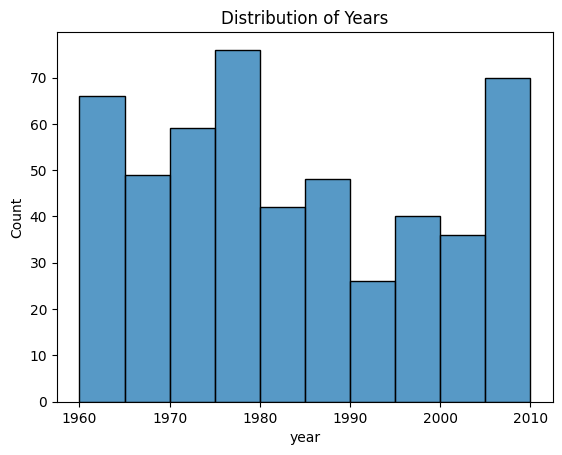

In [13]:
sns.histplot(df["year"].dropna())
plt.title("Distribution of Years")

Text(0.5, 1.0, 'Distribution of country with missing values removed')

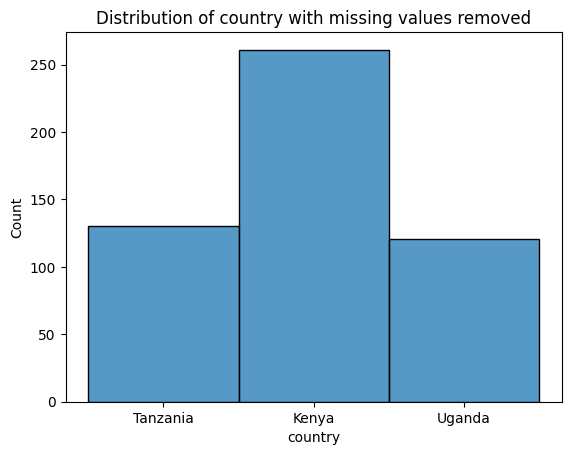

In [18]:
sns.histplot(df["country"].dropna())
plt.title(f"Distribution of Countries")

Text(0.5, 1.0, 'Distribution of property ownership with missing values removed')

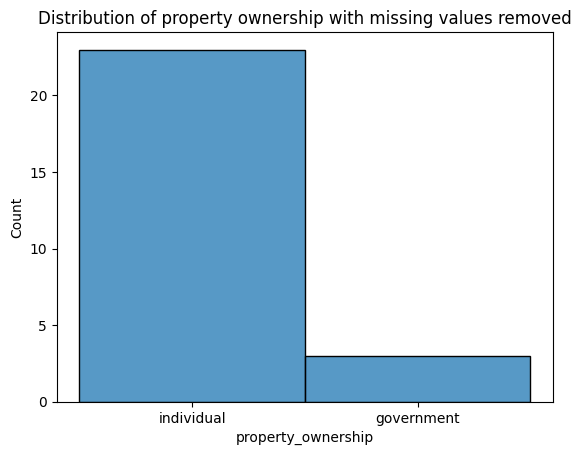

In [20]:
sns.histplot(df["property_ownership"].dropna())
plt.title(f"Distribution of property ownership with missing values removed")

Text(0.5, 1.0, 'Distribution of perpetrators group size with missing values removed')

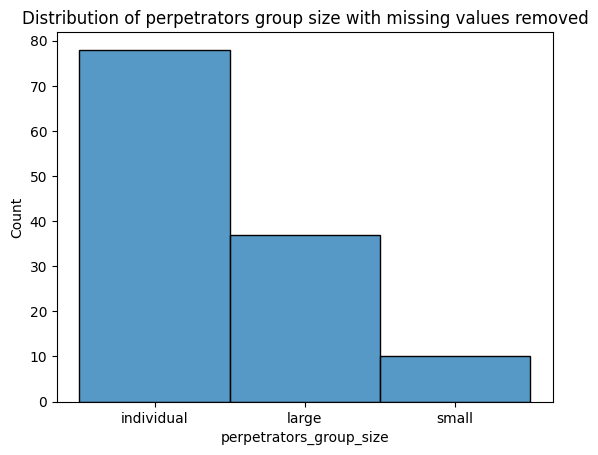

In [21]:
sns.histplot(df["perpetrators_group_size"].dropna())
plt.title(f"Distribution of perpetrators group size with missing values removed")

Text(0.5, 1.0, 'Distribution of perpetrator sex with missing values removed')

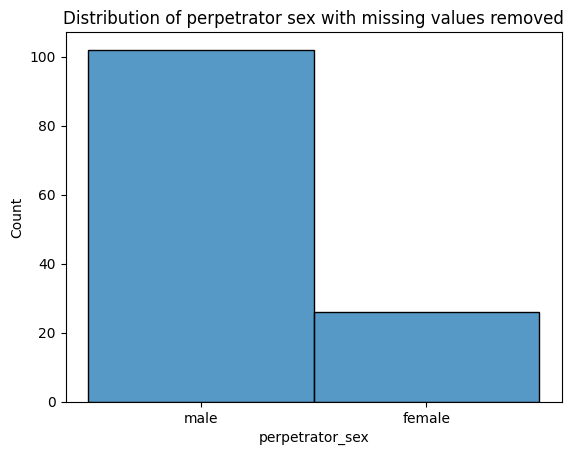

In [22]:
sns.histplot(df["perpetrator_sex"].dropna())
plt.title(f"Distribution of perpetrator sex with missing values removed")

Text(0.5, 1.0, 'Distribution of victims group size with missing values removed')

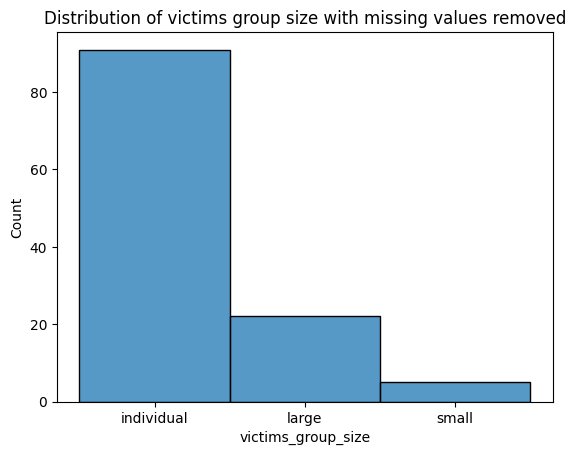

In [23]:
sns.histplot(df["victims_group_size"].dropna())
plt.title(f"Distribution of victims group size with missing values removed")

Text(0.5, 1.0, 'Distribution of victims sex with missing values removed')

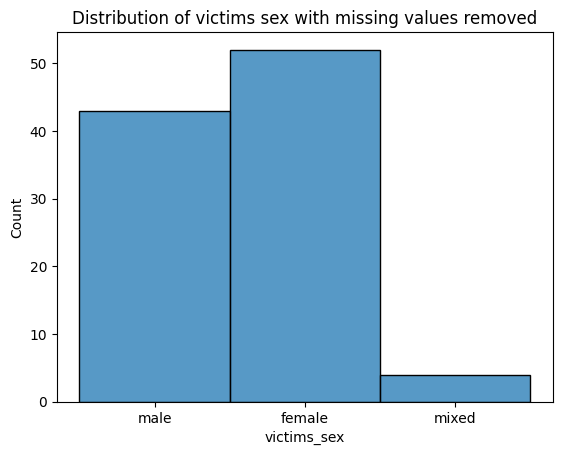

In [26]:
sns.histplot(df[df["victims_sex"].isin(["male", "female", "mixed"])]["victims_sex"])
plt.title(f"Distribution of victims sex with missing values removed")